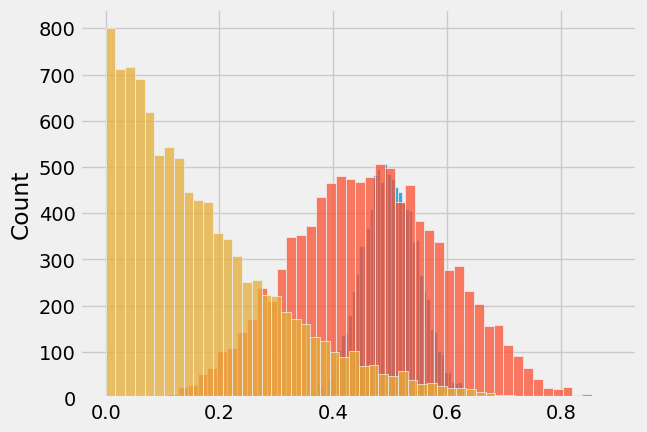

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as graph
import seaborn as sns

graph.style.use('fivethirtyeight')


# Hyperparameters
k = 3  # number of options to pick between
true_dists = [
    stats.beta(a=50, b=50),
    stats.beta(a=6, b=7),
    stats.beta(a=1, b=5)
]

for dist in true_dists:
    sns.histplot(dist.rvs(10_000))
graph.show()


def sample_from_true(k):
    return stats.bernoulli(p=true_dists[k].rvs()).rvs()

In [2]:
class ThompsonSampler:
    def __init__(self, k):
        self.n_updates = 0
        self.k = k
        self.params = [[1, 1] for _ in range(k)]  # Assumes bern output and beta posterior. Prior is unif(0, 1) to start

    def get_choice_dist(self):
        return [sum(x)-2 for x in self.params]

    def update(self):
        """
        1. sample which action k to take
        2. Observe the outcome
        3. Update the kth params with the output from the sampling

        Return the choice made `k`
        """
        # Step 1)
        k = np.argmax([
            stats.beta(ak, bk).rvs()
            for ak, bk in self.params
        ])

        # Step 2)
        obs = sample_from_true(k)

        # Step 3) If obs == 1 a+=1 else b+=1
        self.params[k][0 if obs == 1 else 1] += 1
        self.n_updates += 1

        return k, obs

    def plot(self):
        graph.title(f'Iter = {self.n_updates:,}')
        for a, b in self.params:
            sns.histplot(stats.beta(a=a, b=b).rvs(10_000))
        graph.show()

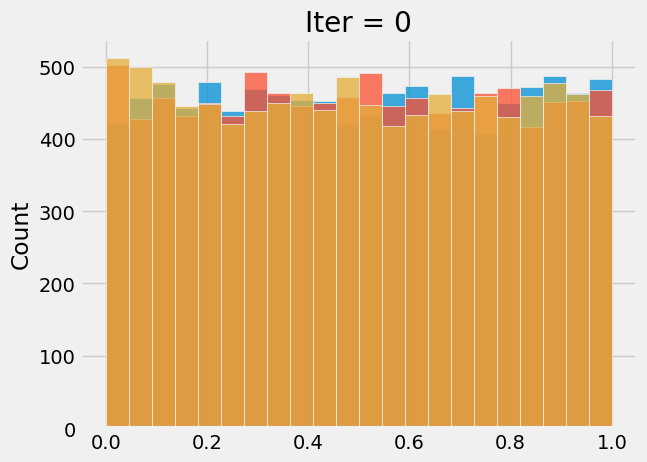

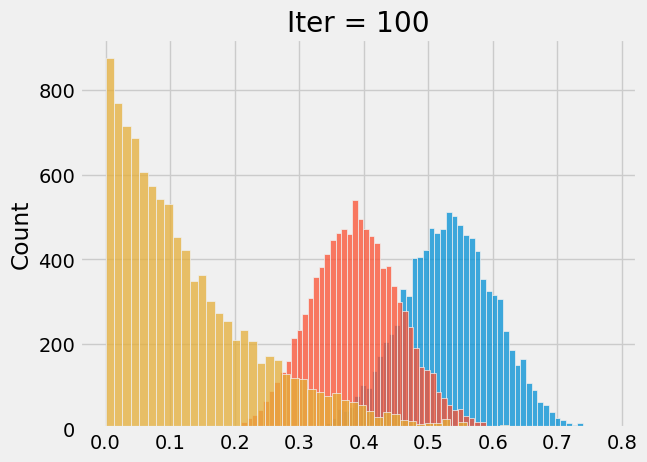

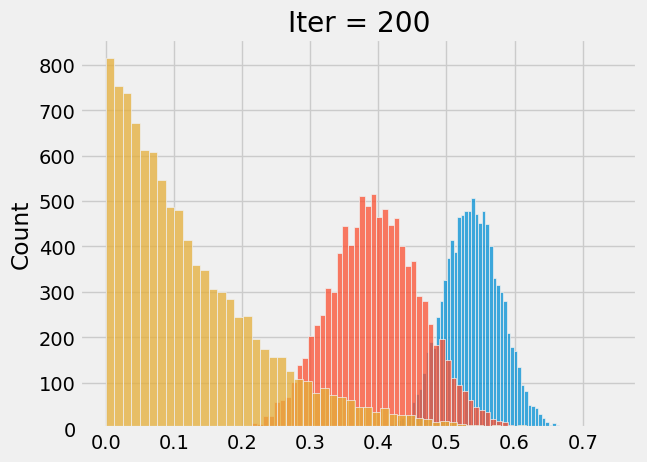

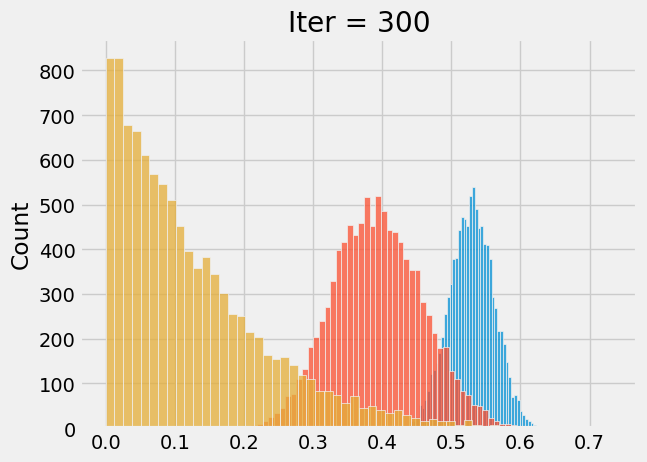

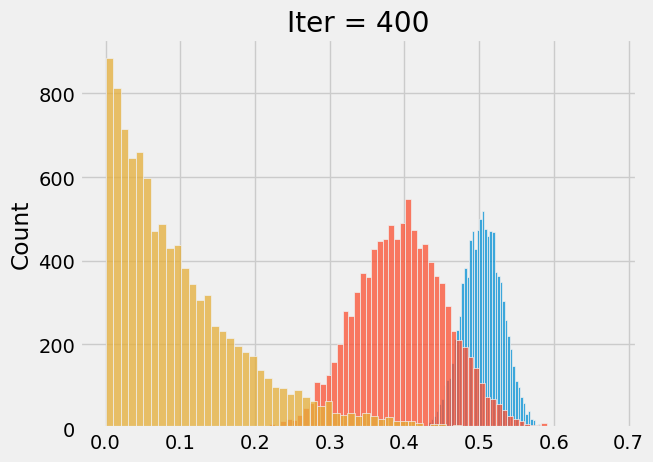

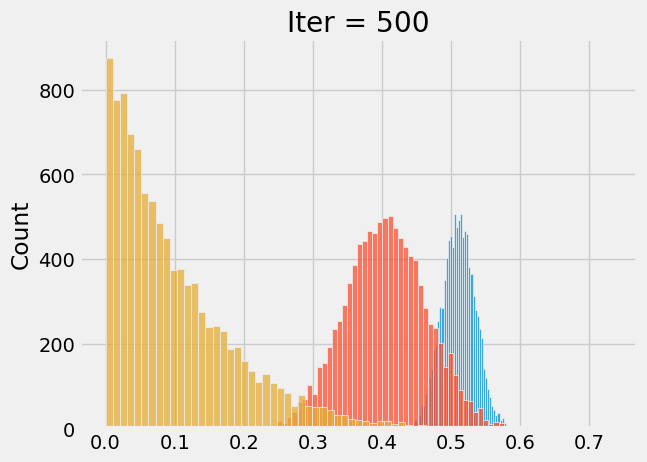

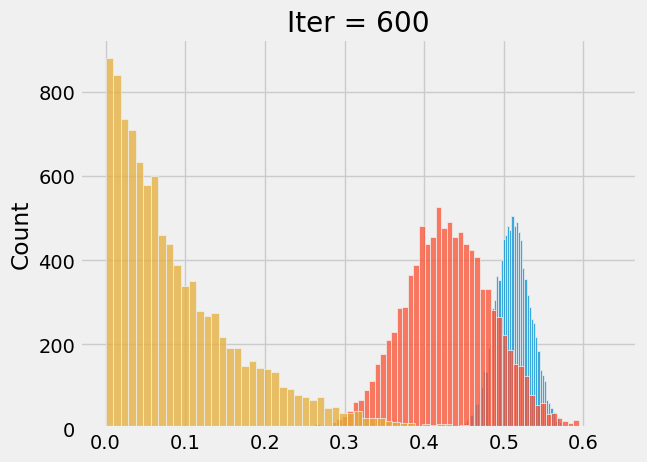

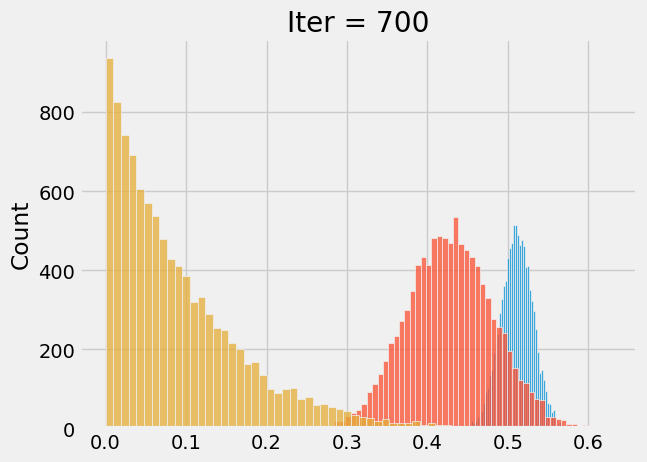

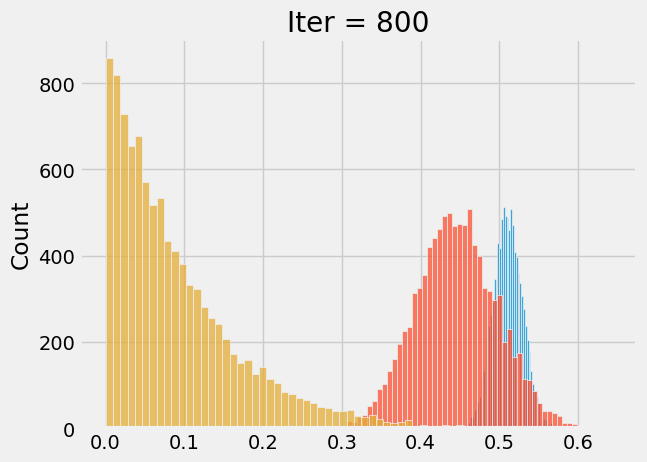

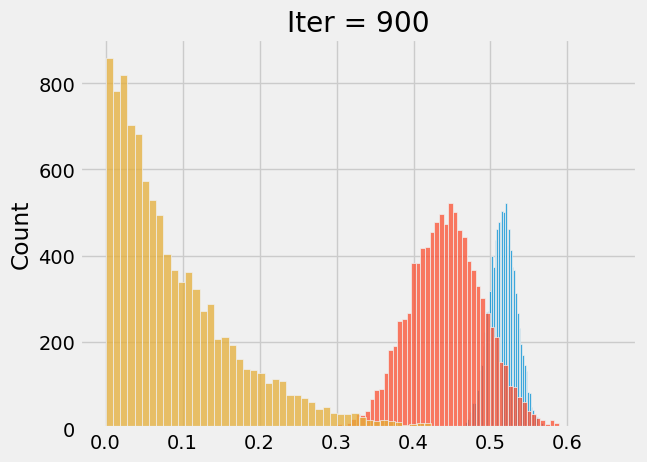

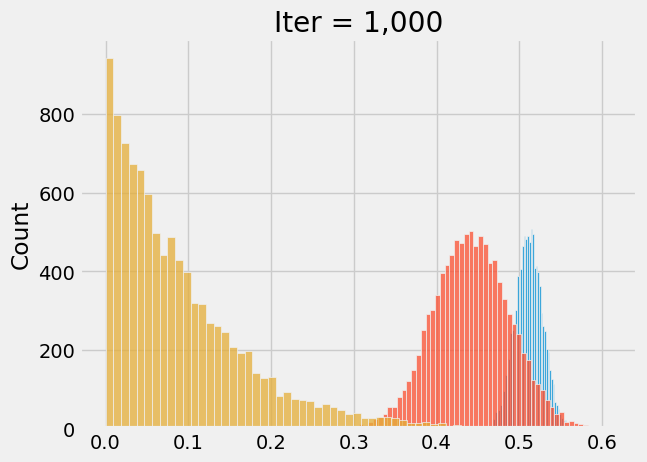

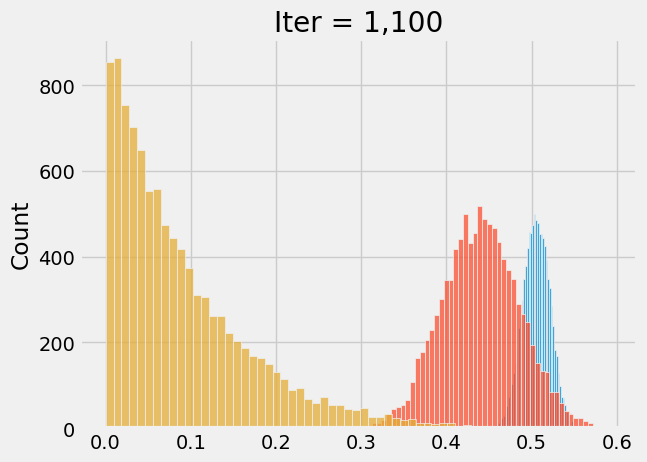

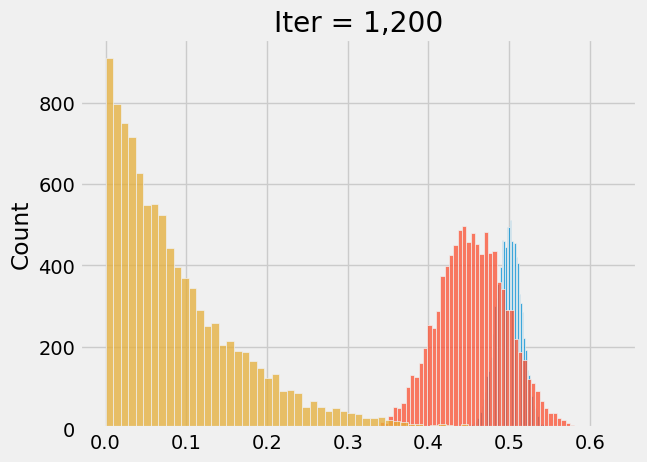

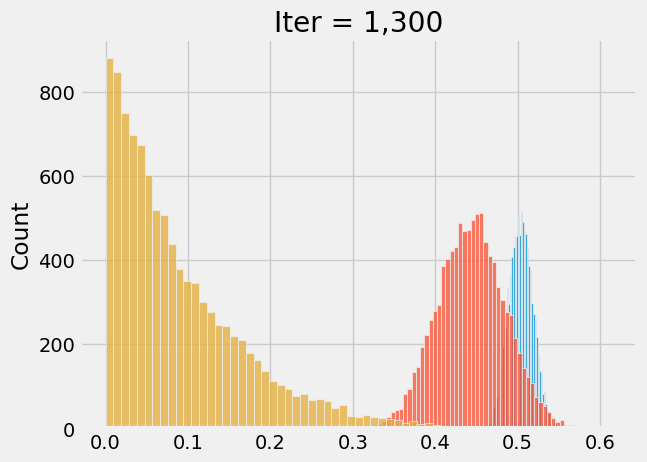

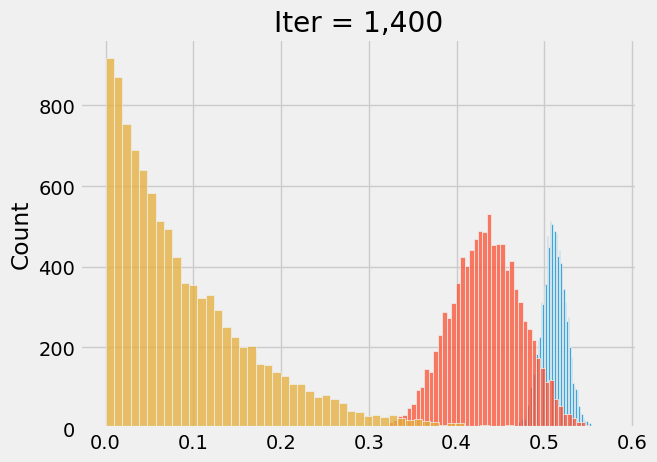

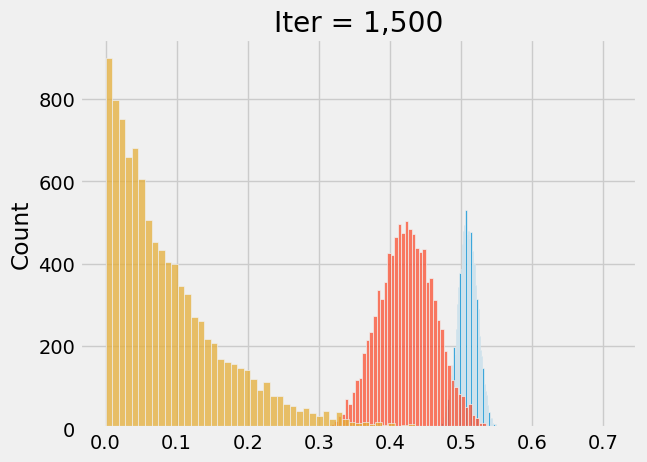

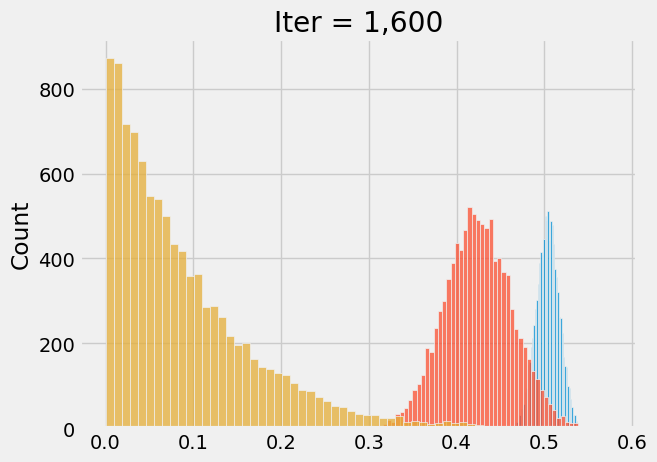

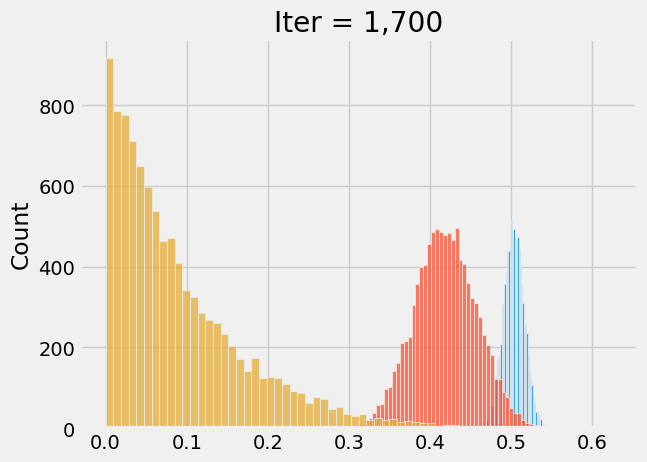

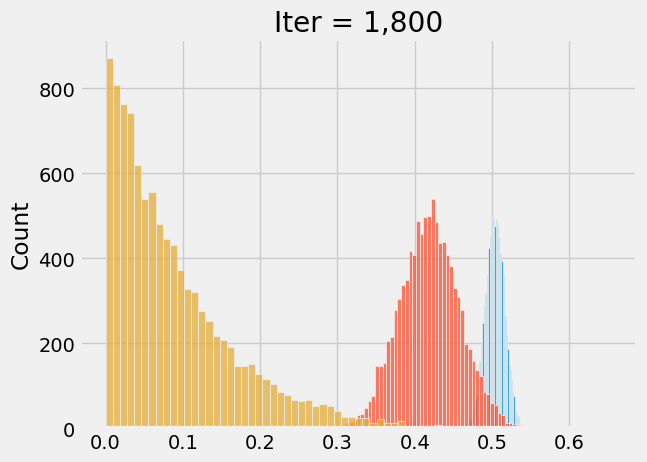

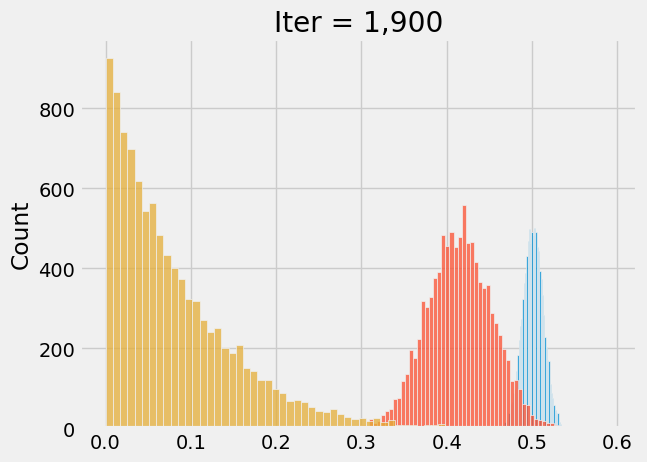

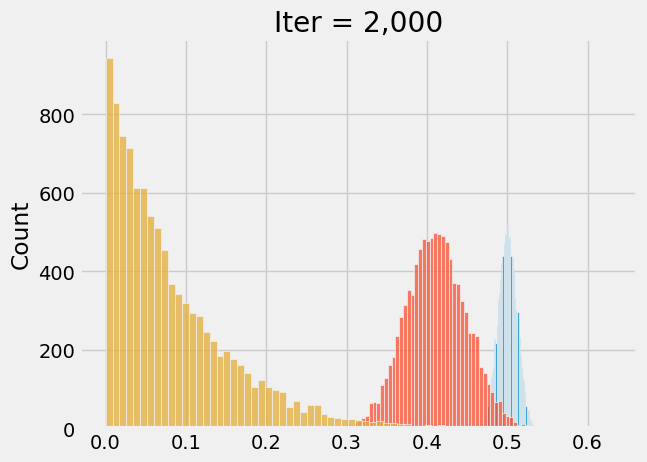

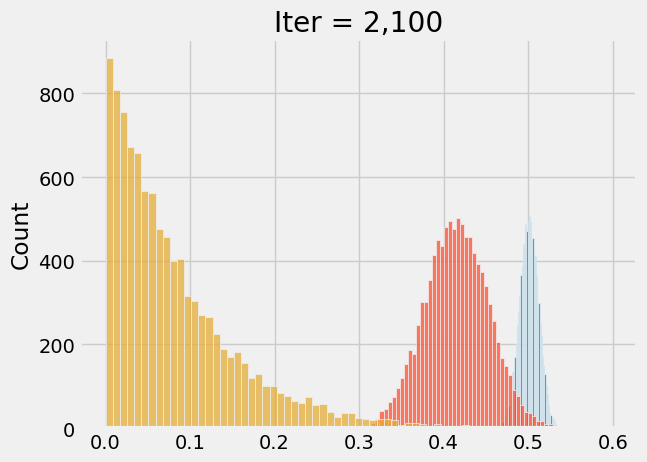

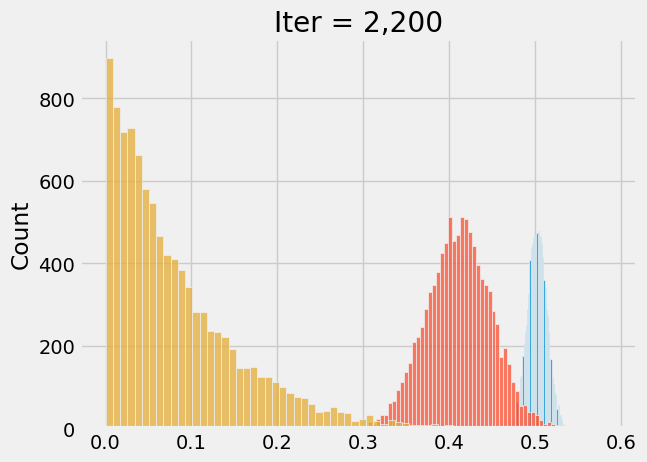

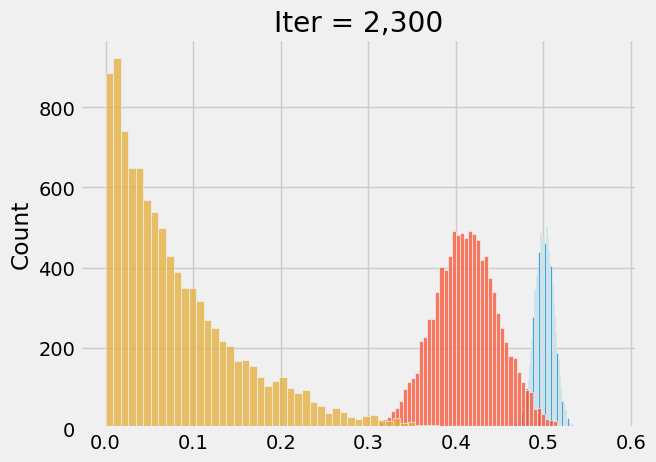

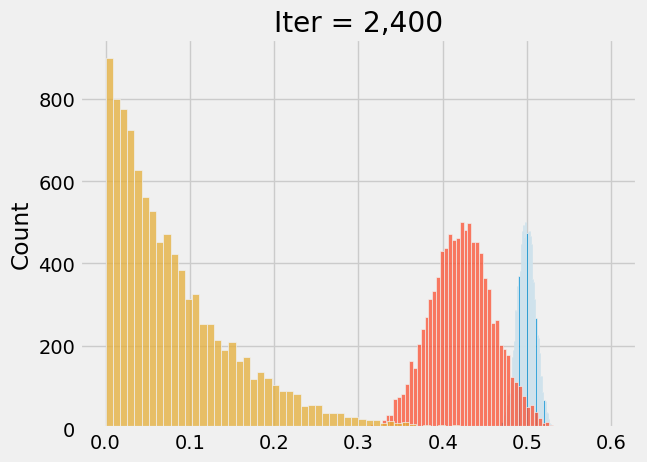

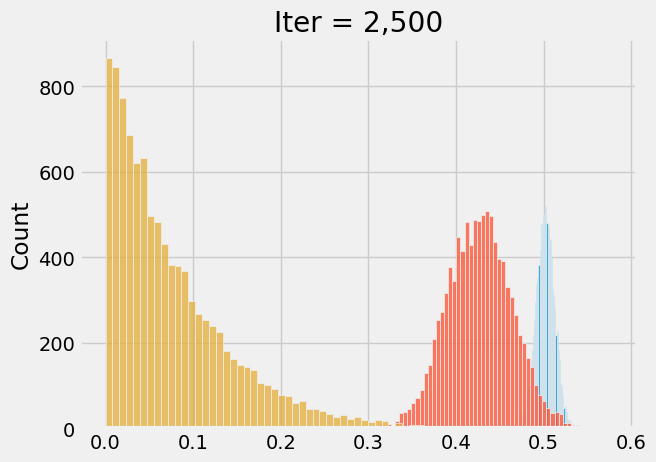

In [3]:
ts = ThompsonSampler(k=k)

# Run updates
n_iters = 2500
hist_choices = []
history = []
for i in range(n_iters):
    if i % 100 == 0:
        ts.plot()

    choice_i, reward_i = ts.update()
    hist_choices.append(choice_i)
    history.append(reward_i)
ts.plot()
hist_choices = np.array(choice_i)
history = np.array(history)

## Calculate the regret overtime

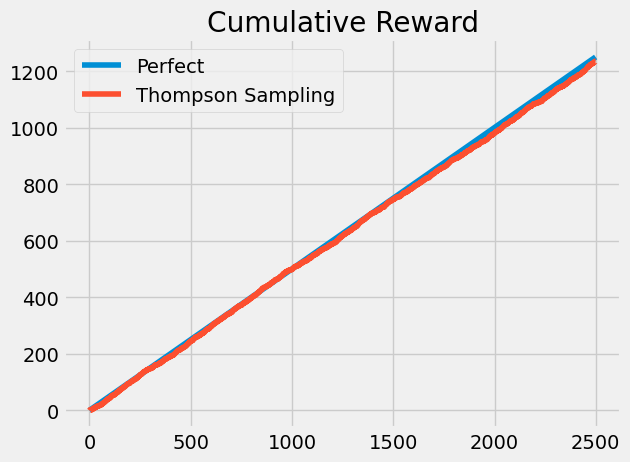

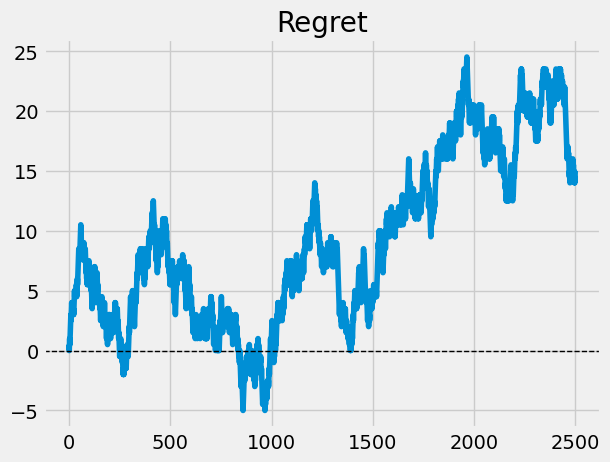

In [4]:
# perfect_history = np.array([sample_from_true(k=0) for _ in range(n_iters)])  # k=0 is the best strategy
perfect_history = np.array([0.5 for _ in range(n_iters)])  # via expected values

graph.title('Cumulative Reward')
graph.plot(np.cumsum(perfect_history), label='Perfect')
graph.plot(np.cumsum(history), label='Thompson Sampling')
graph.legend()
graph.show()

graph.title('Regret')
graph.plot(np.cumsum(perfect_history) - np.cumsum(history))
# graph.plot(
#     (np.cumsum(perfect_history) - np.cumsum(history)) / (1+np.arange(n_iters))
# )
graph.axhline(0, linestyle='--', linewidth=1, color='black')
graph.show()

In [5]:
print(ts.params)
print('Choice distribution:', np.array(ts.get_choice_dist()) / n_iters)

[[1162, 1155], [75, 101], [1, 12]]
Choice distribution: [0.926  0.0696 0.0044]
